# init

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import difflib
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from typing import List, Tuple, Dict, Any
import matplotlib.pyplot as plt

seed = 18022004
np.random.seed(seed)

/drive2/phatnt/zTrans/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_prefix: str = 'data'
repo_prefix: str = f'{data_prefix}/repos'

model_id: str = 'deepseek-ai/deepseek-coder-6.7b-instruct'

# create dataset

In [3]:
max_token: int = 512
data_name: str = f'migration_others_dataset_cutoff_{max_token}.parquet'
data_df: pd.DataFrame = pd.read_parquet(f'{data_prefix}/{data_name}', engine = 'pyarrow')

In [4]:
data_df.reset_index(drop = True, inplace = True)
data_df.loc[:, 'id'] = data_df.index

In [5]:
from datasets import Dataset, DatasetDict

hf_dataset = Dataset.from_pandas(data_df)

train_test_split = hf_dataset.train_test_split(test_size = 0.2, seed = seed)

val_test_split = train_test_split['test'].train_test_split(test_size = 0.5, seed = seed)

final_datasets = DatasetDict({
    'train': train_test_split['train'],
    'validation': val_test_split['train'],
    'test': val_test_split['test']
})

final_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'fromLib', 'toLib', 'repoName', 'prevCommit', 'startCommit', 'endCommit', 'fileName', 'startCommitChanges', 'endCommitChanges', 'total_methods_before', 'total_methods_after', 'class_before', 'class_after', 'method_before_name', 'method_after_name', 'method_before', 'method_after', 'method_diff', 'method_before_modifiers', 'method_after_modifiers', 'method_before_return_type', 'method_after_return_type', 'method_before_parameters', 'method_after_parameters', 'method_before_signature', 'method_after_signature', 'method_before_signature_no_mod', 'method_after_signature_no_mod', 'added', 'removed'],
        num_rows: 39827
    })
    validation: Dataset({
        features: ['id', 'fromLib', 'toLib', 'repoName', 'prevCommit', 'startCommit', 'endCommit', 'fileName', 'startCommitChanges', 'endCommitChanges', 'total_methods_before', 'total_methods_after', 'class_before', 'class_after', 'method_before_name', 'method_after_name', 'metho

In [6]:
from huggingface_hub import login
import os

access_token = os.environ.get('HF_TOKEN')

login(token = access_token)

username = 'blackwhite1337'
dataset_name = f'zTrans_dataset_{max_token}'

final_datasets.push_to_hub(f'{username}/{dataset_name}')

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
Uploading the dataset shards: 100%|██████████| 1/1 [00:08<00:00,  8.98s/it]
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/blackwhite1337/zTrans_dataset_512/commit/214f90cd2d693f44dc19bc8e85cf229d23c3bd34', commit_message='Upload dataset', commit_description='', oid='214f90cd2d693f44dc19bc8e85cf229d23c3bd34', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/blackwhite1337/zTrans_dataset_512', endpoint='https://huggingface.co', repo_type='dataset', repo_id='blackwhite1337/zTrans_dataset_512'), pr_revision=None, pr_num=None)

In [7]:
train_df: pd.DataFrame = final_datasets['train'].to_pandas()
val_df: pd.DataFrame = final_datasets['validation'].to_pandas()
test_df: pd.DataFrame = final_datasets['test'].to_pandas()

main_dataset_name: str = data_name.split('.')[0]
train_df.to_parquet(f'{data_prefix}/{main_dataset_name}_train.parquet', engine = 'pyarrow')
val_df.to_parquet(f'{data_prefix}/{main_dataset_name}_val.parquet', engine = 'pyarrow')
test_df.to_parquet(f'{data_prefix}/{main_dataset_name}_test.parquet', engine = 'pyarrow')

# statistics

* special cases

group by migration:
- number of classes
-  number of methods

group by class:
- number of methods (add, remove, total)
- number of lines (add, remove, total)

group by method:
- number of lines (add, remove, total)
- number of tokens (add, remove, total)

## init data

In [8]:
# data_name = 'ori_data_method_treesitter.parquet'
data_name = 'migration_others_method_no_code.parquet'

data_df: pd.DataFrame = pd.read_parquet(f'{data_prefix}/{data_name}', engine = 'pyarrow')

## data filter (done)

### filtering

In [9]:
print(len(data_df))

171779


In [10]:
# remove all special cases
# special cases are neither methods_before nor methods_after is blank
filtered_df: pd.DataFrame = data_df[(data_df['method_before'].str.len() > 0) & (data_df['method_after'].str.len() > 0)]

print(f'filtered set: {len(filtered_df)}')
# filtered_df.reset_index(drop = True, inplace = True)
# filtered_df.loc[:, 'id'] = filtered_df.index

print(f'remaining data: {len(data_df) - len(filtered_df)}')

filtered set: 55958
remaining data: 115821


In [11]:
special_cases: pd.DataFrame = data_df[~data_df.index.isin(filtered_df.index)]

print(f'special_cases: {len(special_cases)}')
print()

# only has before
special_cases_before: pd.DataFrame = special_cases[
    (special_cases['method_before'].str.len() > 0) &
    (special_cases['method_after'].str.len() == 0)
]
# only has after
special_cases_after: pd.DataFrame = special_cases[
    (special_cases['method_after'].str.len() > 0) &
    (special_cases['method_before'].str.len() == 0)
]
# has both code but ????????
special_cases_remain: pd.DataFrame = special_cases[
    ~(
        special_cases.index.isin(special_cases_before.index) |
        special_cases.index.isin(special_cases_after.index)
    )
]

# # merge filtered_df and special_cases_remain
# filtered_df = pd.concat([first_filtered_df, special_cases_remain], ignore_index = True)
# filtered_df = filtered_df.sort_index()

special_cases_both: pd.DataFrame = special_cases[(special_cases['method_before'].str.len() == 0) & (special_cases['method_after'].str.len() == 0)]
# special_cases_remain = special_cases_remain[~special_cases_remain.index.isin(special_cases_after.index)]

print(f'special cases before: {len(special_cases_before)}')
print(f'special cases after: {len(special_cases_after)}')
print(f'special cases remain: {len(special_cases_remain)}')
print(f'special cases both: {len(special_cases_both)}')

print(f'check if all len equals: {(len(special_cases_before) + len(special_cases_after) + len(special_cases_remain)) == len(special_cases)}')
print()

print(f'filtered len: {len(filtered_df)}')
print(f'percentage to before set: {len(filtered_df) / (len(filtered_df) + len(special_cases_before))}')
print(f'percentage to after set: {len(filtered_df) / (len(filtered_df) + len(special_cases_after))}')

special_cases: 115821

special cases before: 51532
special cases after: 64289
special cases remain: 0
special cases both: 0
check if all len equals: True

filtered len: 55958
percentage to before set: 0.5205879616708531
percentage to after set: 0.4653588031302236


In [12]:
# filtered_df.to_parquet(f'{data_prefix}/migration_others_method_no_code_filtered.parquet', engine = 'pyarrow')

### why special_cases_remain legit??????? (i reset the index and fucked up the data)

In [ ]:
print(special_cases_remain.iloc[0]['method_before_signature'], special_cases_remain.iloc[0]['class_before'])
print(special_cases_remain.iloc[0]['method_after_signature'], special_cases_remain.iloc[0]['class_before'])
print('-' * 100)
print(special_cases_remain.iloc[0]['method_before'])
print('-' * 100)
print(special_cases_remain.iloc[0]['method_after'])
print('-' * 100)
print(special_cases_remain.iloc[0]['method_diff'])

IndexError: single positional indexer is out-of-bounds

: 

In [ ]:
wtf: pd.DataFrame = special_cases_remain[(special_cases_remain['method_before'].str.len() > 0) & (special_cases_remain['method_after'].str.len() > 0)]
print(len(wtf) == len(special_cases_remain))

wtf2: pd.DataFrame = special_cases_remain[(special_cases_remain.index.isin(filtered_df.index))]
print(len(wtf2))

True
0


In [ ]:
special_cases_after['method_before']

55958                                                      
55959                                                      
55960     public synchronized boolean store(PnfsId pnfsI...
55965     private synchronized String\n        getSystem...
55967     @Override\n        public void run()\n        ...
                                ...                        
171773    @Test\n    public void shouldCollectFieldsOfTw...
171774    @Override\n        protected void before() thr...
171775    @Test\n    public void shouldCollectFieldsOfOn...
171776    @Test\n    public void shouldAskPackAndClassNa...
171778    @Configuration\n    public Option[] config()\n...
Name: method_before, Length: 82391, dtype: object

### removed and added methods

In [ ]:
removed_methods_df_by_name: pd.DataFrame = special_cases_before[
    ~(
        special_cases_before['method_before_name'].isin(special_cases_after['method_after_name']) &
        special_cases_before['repoName'].isin(special_cases_after['repoName']) &
        special_cases_before['startCommit'].isin(special_cases_after['startCommit']) &
        special_cases_before['endCommit'].isin(special_cases_after['endCommit'])
    )
]
remain_before_methods_df_by_name: pd.DataFrame = special_cases_before[
    ~(
        special_cases_before['id'].isin(removed_methods_df_by_name.index)
    )
]
added_after_methods_df_by_name: pd.DataFrame = special_cases_after[
    ~(
        special_cases_after['method_after_name'].isin(remain_before_methods_df_by_name['method_before_name']) &
        special_cases_after['repoName'].isin(remain_before_methods_df_by_name['repoName']) &
        special_cases_after['startCommit'].isin(remain_before_methods_df_by_name['startCommit']) &
        special_cases_after['endCommit'].isin(remain_before_methods_df_by_name['endCommit'])
    )
]
remain_added_methods_df_by_name: pd.DataFrame = special_cases_after[
    ~(
        special_cases_after.index.isin(added_after_methods_df_by_name.index)
    )
]

print('filtered with same repo and migration')
print(f'removed before methods filtered by name: {len(removed_methods_df_by_name)}')
print(f'remain before methods filtered by name: {len(remain_before_methods_df_by_name)}')
print()
print(f'added after methods filtered by name: {len(added_after_methods_df_by_name)}')
print(f'remain after methods filtered by name: {len(remain_added_methods_df_by_name)}')
print('-' * 20)

print(f'percentage removed to the before set: {len(removed_methods_df_by_name) / len(special_cases_before)}')
print(f'percentage removed to the after set: {len(removed_methods_df_by_name) / len(special_cases_after)}')
print()
print(f'percentage added to the before set: {len(added_after_methods_df_by_name) / len(special_cases_before)}')
print(f'percentage added to the after set: {len(added_after_methods_df_by_name) / len(special_cases_after)}')

del removed_methods_df_by_name
del remain_before_methods_df_by_name
del added_after_methods_df_by_name
del remain_added_methods_df_by_name

filtered with same repo and migration
removed before methods filtered by name: 11080
remain before methods filtered by name: 40452

added after methods filtered by name: 20269
remain after methods filtered by name: 44020
--------------------
percentage removed to the before set: 0.21501203135915548
percentage removed to the after set: 0.17234674672183423

percentage added to the before set: 0.3933284172941085
percentage added to the after set: 0.3152794412730016


In [ ]:
removed_before_methods_df_by_signature: pd.DataFrame = special_cases_before[
    ~(
        special_cases_before['method_before_signature'].isin(special_cases_after['method_after_signature']) &
        special_cases_before['repoName'].isin(special_cases_after['repoName']) &
        special_cases_before['startCommit'].isin(special_cases_after['startCommit']) &
        special_cases_before['endCommit'].isin(special_cases_after['endCommit'])
    )
]
remain_before_methods_df_by_signature: pd.DataFrame = special_cases_before[
    ~(
        special_cases_before['id'].isin(removed_before_methods_df_by_signature.index)
    )
]
added_after_methods_df_by_signature: pd.DataFrame = special_cases_after[
    ~(
        special_cases_after['method_after_signature'].isin(remain_before_methods_df_by_signature['method_before_signature']) &
        special_cases_after['repoName'].isin(remain_before_methods_df_by_signature['repoName']) &
        special_cases_after['startCommit'].isin(remain_before_methods_df_by_signature['startCommit']) &
        special_cases_after['endCommit'].isin(remain_before_methods_df_by_signature['endCommit'])
    )
]
remain_after_methods_df_by_signature: pd.DataFrame = special_cases_after[
    ~(
        special_cases_after.index.isin(added_after_methods_df_by_signature.index)
    )
]

print('filtered with same repo and migration')
print(f'removed before methods filtered by signature: {len(removed_before_methods_df_by_signature)}')
print(f'remain before methods filtered by signature: {len(remain_before_methods_df_by_signature)}')
print()
print(f'added after methods filtered by signature: {len(added_after_methods_df_by_signature)}')
print(f'remain after methods filtered by signature: {len(remain_after_methods_df_by_signature)}')
print('-' * 20)

print(f'percentage removed to the before set: {len(removed_before_methods_df_by_signature) / len(special_cases_before)}')
print(f'percentage removed to the after set: {len(removed_before_methods_df_by_signature) / len(special_cases_after)}')
print()
print(f'percentage added to the before set: {len(added_after_methods_df_by_signature) / len(special_cases_before)}')
print(f'percentage added to the after set: {len(added_after_methods_df_by_signature) / len(special_cases_after)}')

del removed_before_methods_df_by_signature
del remain_before_methods_df_by_signature
del added_after_methods_df_by_signature
del remain_after_methods_df_by_signature

filtered with same repo and migration
removed before methods filtered by signature: 46478
remain before methods filtered by signature: 5054

added after methods filtered by signature: 59471
remain after methods filtered by signature: 4818
--------------------
percentage removed to the before set: 0.9019250174648762
percentage removed to the after set: 0.7229541601207049

percentage added to the before set: 1.1540596134440735
percentage added to the after set: 0.9250571637449642


filtered with same repo and migration
removed before methods filtered by signature + class: 47458
remain before methods filtered by signature + class: 4074

added after methods filtered by signature + class: 61444
remain after methods filtered by signature + class: 2845
--------------------
percentage removed to the before set: 0.9209423270977257
percentage removed to the after set: 0.7381978254444773

percentage added to the before set: 1.1923465031436777
percentage added to the after set: 0.9557467062794568


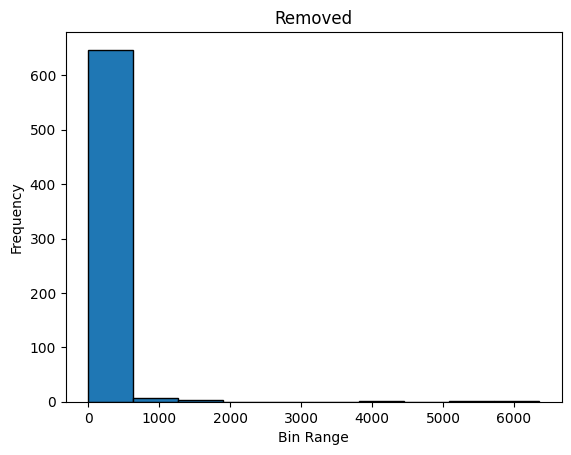

count     661.000000
mean       71.797277
std       401.669419
min         1.000000
25%         2.000000
50%         7.000000
75%        23.000000
max      6353.000000
dtype: float64


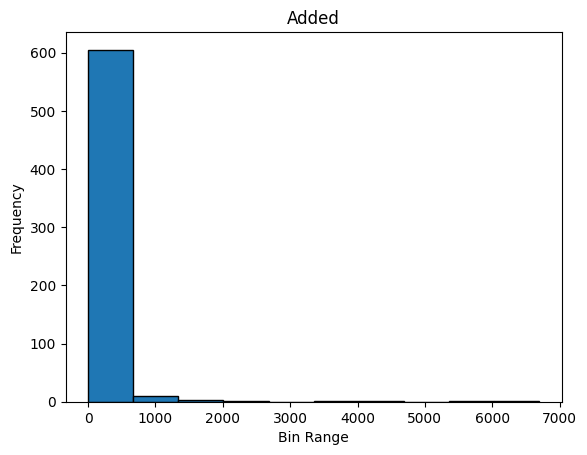

count     623.000000
mean       98.009631
std       516.337323
min         1.000000
25%         3.000000
50%         9.000000
75%        26.000000
max      6696.000000
dtype: float64


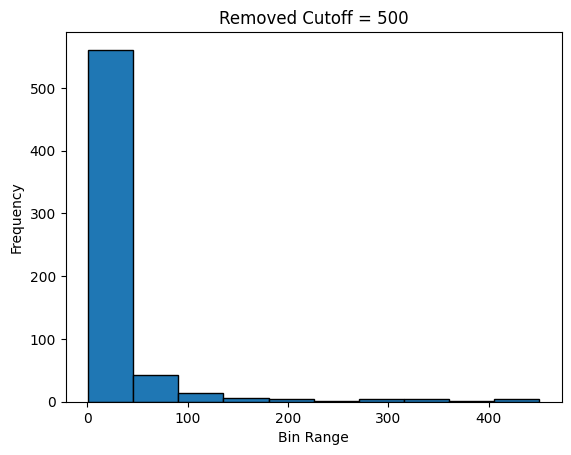

count    643.000000
mean      25.536547
std       58.884991
min        1.000000
25%        2.000000
50%        6.000000
75%       21.000000
max      450.000000
dtype: float64


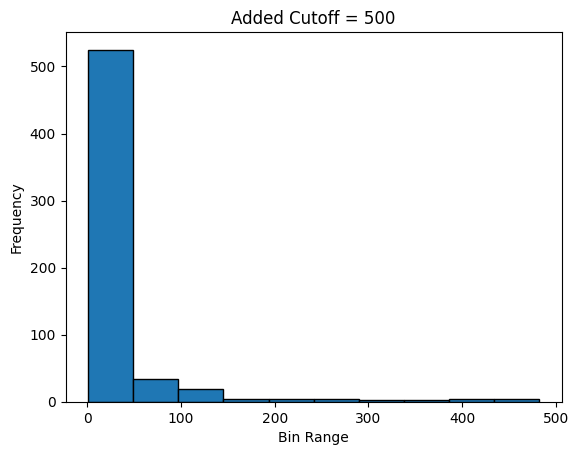

count    602.000000
mean      29.003322
std       65.887743
min        1.000000
25%        3.000000
50%        8.000000
75%       24.000000
max      482.000000
dtype: float64


In [ ]:
removed_before_methods_df_by_signature_class: pd.DataFrame = special_cases_before[
    ~(
        special_cases_before['method_before_signature'].isin(special_cases_after['method_after_signature']) &
        (special_cases_before['class_before'].isin(special_cases_after['class_after'])) &
        special_cases_before['repoName'].isin(special_cases_after['repoName']) &
        special_cases_before['startCommit'].isin(special_cases_after['startCommit']) &
        special_cases_before['endCommit'].isin(special_cases_after['endCommit'])
    )
]
remain_before_methods_df_by_signature_class: pd.DataFrame = special_cases_before[
    ~(
        special_cases_before['id'].isin(removed_before_methods_df_by_signature_class.index)
    )
]
added_after_methods_df_by_signature_class: pd.DataFrame = special_cases_after[
    ~(
        special_cases_after['method_after_signature'].isin(remain_before_methods_df_by_signature_class['method_before_signature']) &
        (special_cases_after['class_after'].isin(special_cases_before['class_before'])) &
        special_cases_after['repoName'].isin(remain_before_methods_df_by_signature_class['repoName']) &
        special_cases_after['startCommit'].isin(remain_before_methods_df_by_signature_class['startCommit']) &
        special_cases_after['endCommit'].isin(remain_before_methods_df_by_signature_class['endCommit'])
    )
]
remain_after_methods_df_by_signature_class: pd.DataFrame = special_cases_after[
    ~(
        special_cases_after.index.isin(added_after_methods_df_by_signature_class.index)
    )
]

print('filtered with same repo and migration')
print(f'removed before methods filtered by signature + class: {len(removed_before_methods_df_by_signature_class)}')
print(f'remain before methods filtered by signature + class: {len(remain_before_methods_df_by_signature_class)}')
print()
print(f'added after methods filtered by signature + class: {len(added_after_methods_df_by_signature_class)}')
print(f'remain after methods filtered by signature + class: {len(remain_after_methods_df_by_signature_class)}')
print('-' * 20)

print(f'percentage removed to the before set: {len(removed_before_methods_df_by_signature_class) / len(special_cases_before)}')
print(f'percentage removed to the after set: {len(removed_before_methods_df_by_signature_class) / len(special_cases_after)}')
print()
print(f'percentage added to the before set: {len(added_after_methods_df_by_signature_class) / len(special_cases_before)}')
print(f'percentage added to the after set: {len(added_after_methods_df_by_signature_class) / len(special_cases_after)}')

unique_repos = removed_before_methods_df_by_signature_class['repoName'].unique()
removed_wtf = []
added_wtf = []
removed_filtered = []
added_filtered = []
cutoff = 500

for id in range(len(unique_repos)):
    migrations_removed_with_repo = removed_before_methods_df_by_signature_class[
        removed_before_methods_df_by_signature_class['repoName'] == unique_repos[id]
    ]
    unique_commits_removed = (
        migrations_removed_with_repo.groupby(['startCommit', 'endCommit'])
        .size()
        .reset_index()
        .rename(columns = {0: 'count'})
    )
    for i in range(len(unique_commits_removed)):
        if (unique_commits_removed.iloc[i]['count'] >= 0):
            removed_wtf.append(unique_commits_removed.iloc[i]['count'])

            if (unique_commits_removed.iloc[i]['count'] <= cutoff):
                removed_filtered.append(unique_commits_removed.iloc[i]['count'])

    migrations_added_with_repo = added_after_methods_df_by_signature_class[
        added_after_methods_df_by_signature_class['repoName'] == unique_repos[id]
    ]
    unique_commits_added = (
        migrations_added_with_repo.groupby(['startCommit', 'endCommit'])
        .size()
        .reset_index()
        .rename(columns = {0: 'count'})
    )
    for i in range(len(unique_commits_added)):
        if (unique_commits_added.iloc[i]['count'] >= 0):
            added_wtf.append(unique_commits_added.iloc[i]['count'])

            if (unique_commits_added.iloc[i]['count'] <= cutoff):
                added_filtered.append(unique_commits_added.iloc[i]['count'])

def plot_hist(data: pd.Series, title: str, num_bins: int) -> None:
    val_min, val_max = data.min(), data.max()
    plt.hist(data, bins = num_bins, range = (val_min, val_max), edgecolor = 'black')
    plt.xlabel('Bin Range')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

    print(data.describe())

removed_wtf = pd.Series(removed_wtf)
added_wtf = pd.Series(added_wtf)
removed_filtered = pd.Series(removed_filtered)
added_filtered = pd.Series(added_filtered)

plot_hist(removed_wtf, 'Removed', 10)
plot_hist(added_wtf, 'Added', 10)
plot_hist(removed_filtered, f'Removed Cutoff = {cutoff}', 10)
plot_hist(added_filtered, f'Added Cutoff = {cutoff}', 10)

del removed_before_methods_df_by_signature_class
del remain_before_methods_df_by_signature_class
del added_after_methods_df_by_signature_class
del remain_after_methods_df_by_signature_class

In [ ]:
removed_before_methods_df_by_signature_nm: pd.DataFrame = special_cases_before[
    ~(
        special_cases_before['method_before_signature_no_mod'].isin(special_cases_after['method_after_signature_no_mod']) &
        special_cases_before['repoName'].isin(special_cases_after['repoName']) &
        (special_cases_before['class_before'].isin(special_cases_after['class_after'])) &
        special_cases_before['startCommit'].isin(special_cases_after['startCommit']) &
        special_cases_before['endCommit'].isin(special_cases_after['endCommit'])
    )
]
remain_before_methods_df_by_signature_nm: pd.DataFrame = special_cases_before[
    ~(
        special_cases_before['id'].isin(removed_before_methods_df_by_signature_nm.index)
    )
]
added_after_methods_df_by_signature_nm: pd.DataFrame = special_cases_after[
    ~(
        special_cases_after['method_after_signature_no_mod'].isin(remain_before_methods_df_by_signature_nm['method_before_signature_no_mod']) &
        special_cases_after['repoName'].isin(remain_before_methods_df_by_signature_nm['repoName']) &
        special_cases_after['startCommit'].isin(remain_before_methods_df_by_signature_nm['startCommit']) &
        special_cases_after['endCommit'].isin(remain_before_methods_df_by_signature_nm['endCommit'])
    )
]
remain_after_methods_df_by_signature_nm: pd.DataFrame = special_cases_after[
    ~(
        special_cases_after.index.isin(added_after_methods_df_by_signature_nm.index)
    )
]

print('filtered with same repo and migration')
print(f'removed before methods filtered by signature no mod: {len(removed_before_methods_df_by_signature_nm)}')
print(f'remain before methods filtered by signature no mod: {len(remain_before_methods_df_by_signature_nm)}')
print()
print(f'added after methods filtered by signature no mod: {len(added_after_methods_df_by_signature_nm)}')
print(f'remain after methods filtered by signature no mod: {len(remain_after_methods_df_by_signature_nm)}')
print('-' * 20)

print(f'percentage removed to the before set: {len(removed_before_methods_df_by_signature_nm) / len(special_cases_before)}')
print(f'percentage removed to the after set: {len(removed_before_methods_df_by_signature_nm) / len(special_cases_after)}')
print()
print(f'percentage added to the before set: {len(added_after_methods_df_by_signature_nm) / len(special_cases_before)}')
print(f'percentage added to the after set: {len(added_after_methods_df_by_signature_nm) / len(special_cases_after)}')

del removed_before_methods_df_by_signature_nm
del remain_before_methods_df_by_signature_nm
del added_after_methods_df_by_signature_nm
del remain_after_methods_df_by_signature_nm

filtered with same repo and migration
removed before methods filtered by signature no mod: 30637
remain before methods filtered by signature no mod: 20895

added after methods filtered by signature no mod: 42798
remain after methods filtered by signature no mod: 21491
--------------------
percentage removed to the before set: 0.594523791042459
percentage removed to the after set: 0.47655119849429917

percentage added to the before set: 0.8305130792517271
percentage added to the after set: 0.6657126413538863


In [ ]:
removed_before_methods_df_by_signature_nm_class: pd.DataFrame = special_cases_before[
    ~(
        special_cases_before['method_before_signature'].isin(special_cases_after['method_after_signature']) &
        (special_cases_before['class_before'].isin(special_cases_after['class_after'])) &
        special_cases_before['repoName'].isin(special_cases_after['repoName']) &
        (special_cases_before['class_before'].isin(special_cases_after['class_after'])) &
        special_cases_before['startCommit'].isin(special_cases_after['startCommit']) &
        special_cases_before['endCommit'].isin(special_cases_after['endCommit'])
    )
]
remain_before_methods_df_by_signature_nm_class: pd.DataFrame = special_cases_before[
    ~(
        special_cases_before['id'].isin(removed_before_methods_df_by_signature_nm_class.index)
    )
]
added_after_methods_df_by_signature_nm_class: pd.DataFrame = special_cases_after[
    ~(
        special_cases_after['method_after_signature'].isin(remain_before_methods_df_by_signature_nm_class['method_before_signature']) &
        (special_cases_after['class_after'].isin(special_cases_before['class_before'])) &
        special_cases_after['repoName'].isin(remain_before_methods_df_by_signature_nm_class['repoName']) &
        special_cases_after['startCommit'].isin(remain_before_methods_df_by_signature_nm_class['startCommit']) &
        special_cases_after['endCommit'].isin(remain_before_methods_df_by_signature_nm_class['endCommit'])
    )
]
remain_after_methods_df_by_signature_nm_class: pd.DataFrame = special_cases_after[
    ~(
        special_cases_after.index.isin(added_after_methods_df_by_signature_nm_class.index)
    )
]

print('filtered with same repo and migration')
print(f'removed before methods filtered by signature no mod + class: {len(removed_before_methods_df_by_signature_nm_class)}')
print(f'remain before methods filtered by signature no mod + class: {len(remain_before_methods_df_by_signature_nm_class)}')
print()
print(f'added after methods filtered by signature no mod + class: {len(added_after_methods_df_by_signature_nm_class)}')
print(f'remain after methods filtered by signature no mod + class: {len(remain_after_methods_df_by_signature_nm_class)}')
print('-' * 20)

print(f'percentage removed to the before set: {len(removed_before_methods_df_by_signature_nm_class) / len(special_cases_before)}')
print(f'percentage removed to the after set: {len(removed_before_methods_df_by_signature_nm_class) / len(special_cases_after)}')
print()
print(f'percentage added to the before set: {len(added_after_methods_df_by_signature_nm_class) / len(special_cases_before)}')
print(f'percentage added to the after set: {len(added_after_methods_df_by_signature_nm_class) / len(special_cases_after)}')

del removed_before_methods_df_by_signature_nm_class
del remain_before_methods_df_by_signature_nm_class
del added_after_methods_df_by_signature_nm_class
del remain_after_methods_df_by_signature_nm_class

filtered with same repo and migration
removed before methods filtered by signature no mod + class: 47458
remain before methods filtered by signature no mod + class: 4074

added after methods filtered by signature no mod + class: 61444
remain after methods filtered by signature no mod + class: 2845
--------------------
percentage removed to the before set: 0.9209423270977257
percentage removed to the after set: 0.7381978254444773

percentage added to the before set: 1.1923465031436777
percentage added to the after set: 0.9557467062794568


In [ ]:
# filtered_df.to_parquet(f'{data_prefix}/migration_other_method_no_code_filtered_special.parquet', engine = 'pyarrow')

In [ ]:
# print(filtered_df.iloc[0]['method_name'])
# print('-' * 100)
# print(filtered_df.iloc[0]['startCode_cleaned'])
# print('-' * 100)
# print(filtered_df.iloc[0]['endCode_cleaned'])

## by migration

## by class

## by method

### process

In [ ]:
data_df['added'] = None
data_df['removed'] = None

data_df['method_before_token'] = None
data_df['method_after_token'] = None
data_df['method_before_line'] = None
data_df['method_after_line'] = None

data_df['added_token'] = None
data_df['removed_token'] = None
data_df['added_line'] = None
data_df['removed_line'] = None

data_df['changed_token'] = None
data_df['changed_line'] = None

In [ ]:
def build_tokenizer(model_id: str = model_id) -> AutoTokenizer:
    tokenizer: AutoTokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code = True,)

    return tokenizer

tokenizer: AutoTokenizer = build_tokenizer(model_id = model_id)

In [ ]:
from threading import Thread

def get_diff(string1: str, string2: str) -> str:
    # Normalize by removing leading/trailing whitespace and replacing tabs with spaces
    normalized1: List[str] = [line.strip().replace('\t', '') for line in string1.splitlines()]
    normalized2: List[str] = [line.strip().replace('\t', '') for line in string2.splitlines()]

    # Generate the diff
    diff: str = difflib.unified_diff(
        normalized1,
        normalized2,
        lineterm = ''
    )
    return '\n'.join(diff)

def extract_diff_changes(diff_str: str) -> Tuple[List[str], List[str], str, str]:
    added_lines: List[str] = []
    removed_lines: List[str] = []

    # Split the diff into lines
    lines: List[str] = diff_str.splitlines()

    # Iterate through the lines
    for line in lines:
        if line.startswith('+') and not line.startswith('+++'):
            # Line added (exclude the '+++' line indicating the file name)
            added_lines.append(line[1:].strip())
        elif line.startswith('-') and not line.startswith('---'):
            # Line removed (exclude the '---' line indicating the file name)
            removed_lines.append(line[1:].strip())

    # Join the lines with '\n'
    added_str: str = '\n'.join(added_lines)
    removed_str: str = '\n'.join(removed_lines)

    return added_lines, removed_lines, added_str, removed_str

def get_token_count(tokenizer: AutoTokenizer, text: str) -> List[int]:
    return len(tokenizer.encode(text, return_tensors = 'pt').to('cpu')[0])

output: Dict = {}

class get_data_by_thread(Thread):
    def __init__(self, sample: pd.DataFrame, id: int, tokenizer: AutoTokenizer) -> None:
        Thread.__init__(self)
        self.sample = sample
        self.id = id
        self.tokenizer = tokenizer

    def run(self) -> None:
        id: int = self.sample['id']
        sample: pd.DataFrame = self.sample
        tokenizer: AutoTokenizer = self.tokenizer

        method_before: str = self.sample['method_before']
        method_after: str = self.sample['method_after']

        method_before_line: int = len(method_before.split('\n'))
        method_after_line: int = len(method_after.split('\n'))

        method_before_token_count: int = get_token_count(tokenizer = tokenizer, text = method_before)
        method_after_token_count: int = get_token_count(tokenizer = tokenizer, text = method_after)

        diff: str = sample['method_diff']
        added_lines, removed_lines, added_str, removed_str = extract_diff_changes(diff)
        added_str_token_count: int = get_token_count(tokenizer = tokenizer, text = added_str)
        removed_str_token_count: int = get_token_count(tokenizer = tokenizer, text = removed_str)

        changed_token: int = added_str_token_count + removed_str_token_count
        changed_line: int = max(len(added_lines), len(removed_lines))

        output[id] = {
            'added': added_str,
            'removed': removed_str,

            'method_before_token_count': method_before_token_count,
            'method_after_token_count': method_after_token_count,
            'method_before_line': method_before_line,
            'method_after_line': method_after_line,

            'added_token': added_str_token_count,
            'removed_token': removed_str_token_count,
            'added_line': len(added_lines),
            'removed_line': len(removed_lines),

            'changed_token': changed_token,
            'changed_line': changed_line,
        }

In [ ]:
def method_statistics_single_thread(data_df: pd.DataFrame) -> pd.DataFrame:
    for id in tqdm(range(len(data_df)), desc = 'Processing method', total = len(data_df)):
        sample = data_df.iloc[id]

        # init
        method_before = sample['method_before']
        method_after = sample['method_after']

        method_before_lines = method_before.split('\n')
        method_after_lines = method_after.split('\n')

        method_before_token_count = get_token_count(tokenizer, method_before)
        method_after_token_count = get_token_count(tokenizer, method_after)

        diff = sample['method_diff']
        added_lines, removed_lines, added_str, removed_str = extract_diff_changes(diff)
        # added_lines_tokens = [get_token_count(tokenizer, line) for line in added_lines]
        # removed_lines_tokens = [get_token_count(tokenizer, line) for line in removed_lines]
        added_str_token_count = get_token_count(tokenizer, added_str)
        removed_str_token_count = get_token_count(tokenizer, removed_str)

        # print(method_before_token_count, method_after_token_count, added_str_token_count, removed_str_token_count)

        # add to the df
        data_df.at[id, 'added'] = added_str
        data_df.at[id, 'removed'] = removed_str

        data_df.at[id, 'method_before_token'] = method_before_token_count
        data_df.at[id, 'method_after_token'] = method_after_token_count
        data_df.at[id, 'method_before_line'] = len(method_before_lines)
        data_df.at[id, 'method_after_line'] = len(method_after_lines)

        data_df.at[id, 'added_token'] = added_str_token_count
        data_df.at[id, 'removed_token'] = removed_str_token_count
        data_df.at[id, 'added_line'] = len(added_lines)
        data_df.at[id, 'removed_line'] = len(removed_lines)

        data_df.at[id, 'changed_token'] = added_str_token_count + removed_str_token_count
        data_df.at[id, 'changed_line'] = max(len(added_lines), len(removed_lines))

    return data_df

def method_statistics_multi_thread(data_df: pd.DataFrame) -> pd.DataFrame:
    threads = []
    thread_cnt = 20

    for id in tqdm(range(len(data_df)), desc = 'Processing method', total = len(data_df)):
        sample = data_df.iloc[id]
        thread = get_data_by_thread(sample = sample)
        thread.start()
        threads.append(thread)

        if ((id + 1) % thread_cnt == 0 or id == len(data_df) - 1):
            # for thread in threads:
            #     thread.start()
            for thread in threads:
                thread.join()

            for sample_id in output.keys():
                data_df.at[sample_id, 'added'] = output[sample_id]['added']
                data_df.at[sample_id, 'removed'] = output[sample_id]['removed']

                data_df.at[sample_id, 'method_before_token'] = output[sample_id]['method_before_token_count']
                data_df.at[sample_id, 'method_after_token'] = output[sample_id]['method_after_token_count']
                data_df.at[sample_id, 'method_before_line'] = output[sample_id]['method_before_line']
                data_df.at[sample_id, 'method_after_line'] = output[sample_id]['method_after_line']

                data_df.at[sample_id, 'added_token'] = output[sample_id]['added_str_token_count']
                data_df.at[sample_id, 'removed_token'] = output[sample_id]['removed_str_token_count']
                data_df.at[sample_id, 'added_line'] = output[sample_id]['added_line']
                data_df.at[sample_id, 'removed_line'] = output[sample_id]['removed_line']

                data_df.at[sample_id, 'changed_token'] = output[sample_id]['changed_token']
                data_df.at[sample_id, 'changed_line'] = output[sample_id]['changed_line']

    return data_df

last_df = method_statistics_multi_thread(data_df = data_df)

last_df.to_parquet(f'{data_prefix}/phat_filtered_method.parquet', engine = 'pyarrow')

### visualization

In [3]:
data_name = 'migration_others_method_no_code_filtered_statistics.parquet'
data_df = pd.read_parquet(f'{data_prefix}/{data_name}', engine = 'pyarrow')

data_df.reset_index(drop = True, inplace = True)
data_df.loc[:, 'id'] = data_df.index

In [ ]:
data_df.columns

Index(['id', 'fromLib', 'toLib', 'repoName', 'prevCommit', 'startCommit',
       'endCommit', 'fileName', 'startCommitChanges', 'endCommitChanges',
       'total_methods_before', 'total_methods_after', 'class_before',
       'class_after', 'method_before_name', 'method_after_name',
       'method_before', 'method_after', 'method_diff',
       'method_before_modifiers', 'method_after_modifiers',
       'method_before_return_type', 'method_after_return_type',
       'method_before_parameters', 'method_after_parameters',
       'method_before_signature', 'method_after_signature',
       'method_before_signature_no_mod', 'method_after_signature_no_mod',
       'added', 'removed', 'method_before_token', 'method_after_token',
       'method_before_line', 'method_after_line', 'added_token',
       'removed_token', 'added_line', 'removed_line', 'changed_token',
       'changed_line'],
      dtype='object')

In [4]:
import matplotlib.pyplot as plt

# Type aliases
# Numeric = Union[int, float]

def plot_column_by_bins(df: pd.DataFrame, column, col_min: int = 0, col_max: int = -1, bins: int = 10) -> None:
    """
    Plot a histogram of a specified DataFrame column, grouped by bins.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The column name to plot.
        bins (int): The number of bins for grouping values. Default is 10.

    Returns:
        None
    """

    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")
    if not pd.api.types.is_numeric_dtype(df[column]):
        raise ValueError(f"Column '{column}' must contain numeric data.")

    if (col_min > col_max):
        col_min, col_max = df[column].min(), df[column].max()

    # Plot the histogram with bin limits
    plt.hist(df[column], bins = bins, range = (col_min, col_max), edgecolor = 'k', alpha = 0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.savefig(f'{data_prefix}/plots/{column}_distribution.png')
    print(f'saved @ {data_prefix}/plots/{column}_distribution.png')
    plt.show()

method_before_token
saved @ data/plots/method_before_token_distribution.png


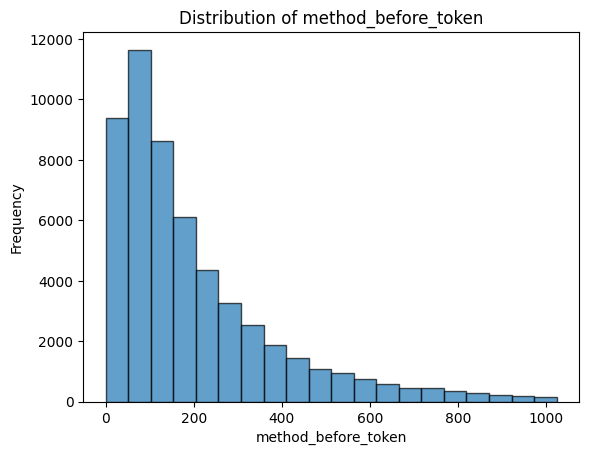

method_before_token >= 1024: 0.024661353157725437
count    55958.000000
mean       239.839022
std        416.107972
min          4.000000
25%         71.000000
50%        142.000000
75%        283.000000
max      55321.000000
Name: method_before_token, dtype: float64
----------------------------------------------------------------------------------------------------
method_after_token
saved @ data/plots/method_after_token_distribution.png


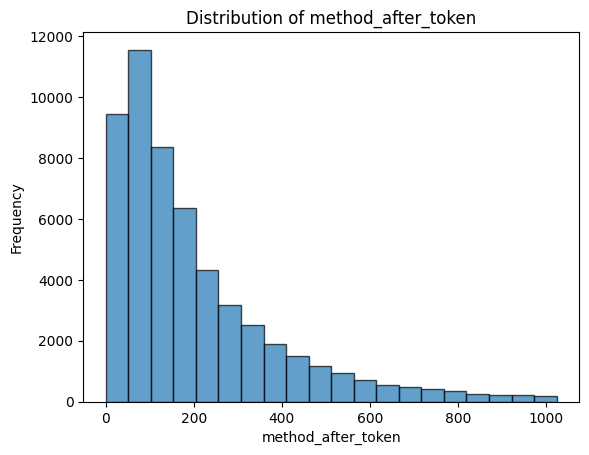

method_after_token >= 1024: 0.026251831730941064
count    55958.000000
mean       242.820312
std        437.702083
min          4.000000
25%         71.000000
50%        144.000000
75%        285.000000
max      55349.000000
Name: method_after_token, dtype: float64
----------------------------------------------------------------------------------------------------
added_token
saved @ data/plots/added_token_distribution.png


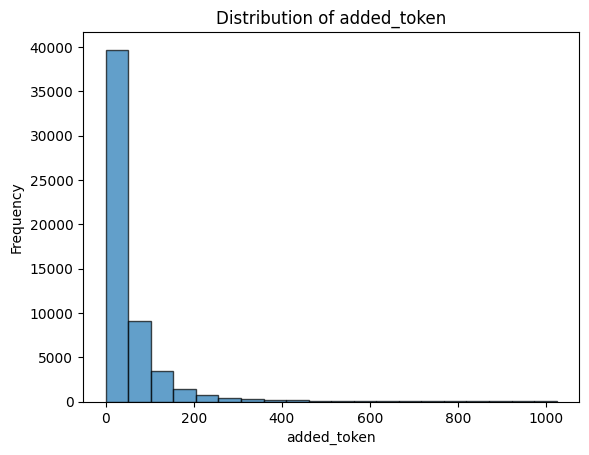

added_token >= 1024: 0.0015368669359162228
count    55958.000000
mean        54.976089
std        155.295519
min          1.000000
25%         13.000000
50%         28.000000
75%         60.000000
max      24610.000000
Name: added_token, dtype: float64
----------------------------------------------------------------------------------------------------
removed_token
saved @ data/plots/removed_token_distribution.png


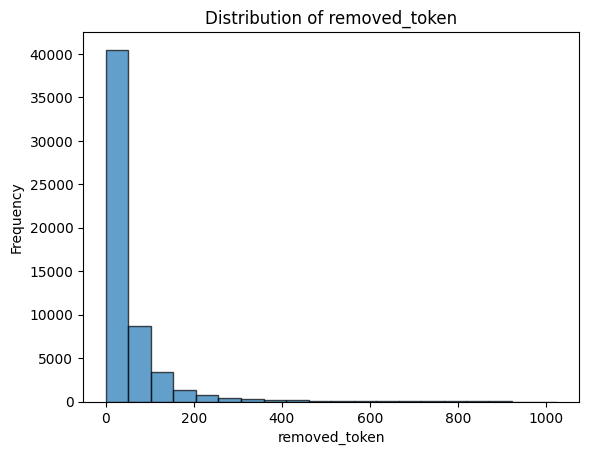

removed_token >= 1024: 0.0014296436613174166
count    55958.000000
mean        52.192251
std        107.826715
min          1.000000
25%         13.000000
50%         26.000000
75%         57.000000
max       6835.000000
Name: removed_token, dtype: float64
----------------------------------------------------------------------------------------------------
changed_token
saved @ data/plots/changed_token_distribution.png


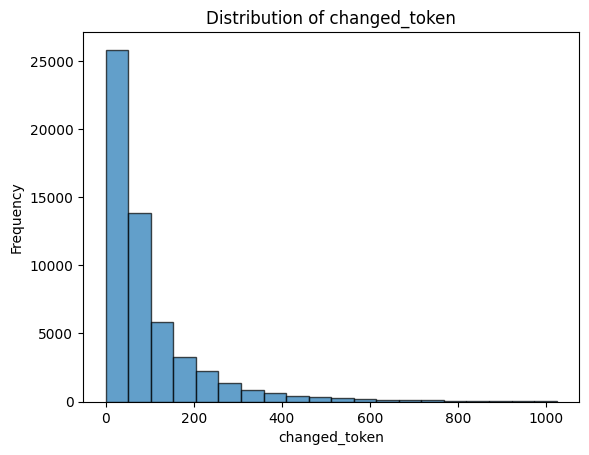

changed_token >= 1024: 0.005486257550305586
count    55958.000000
mean       107.168341
std        243.605418
min          2.000000
25%         29.000000
50%         56.000000
75%        118.000000
max      31445.000000
Name: changed_token, dtype: float64
----------------------------------------------------------------------------------------------------
method_before_line
saved @ data/plots/method_before_line_distribution.png


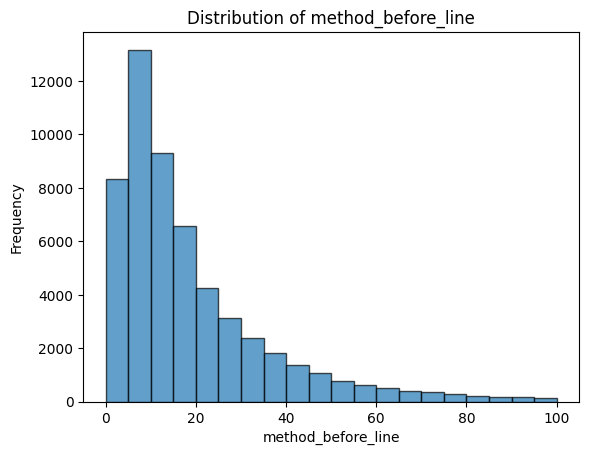

method_before_line >= 100: 0.018424532685228208
count    55958.000000
mean        20.988473
std         31.484388
min          1.000000
25%          6.000000
50%         13.000000
75%         25.000000
max       3335.000000
Name: method_before_line, dtype: float64
----------------------------------------------------------------------------------------------------
method_after_line
saved @ data/plots/method_after_line_distribution.png


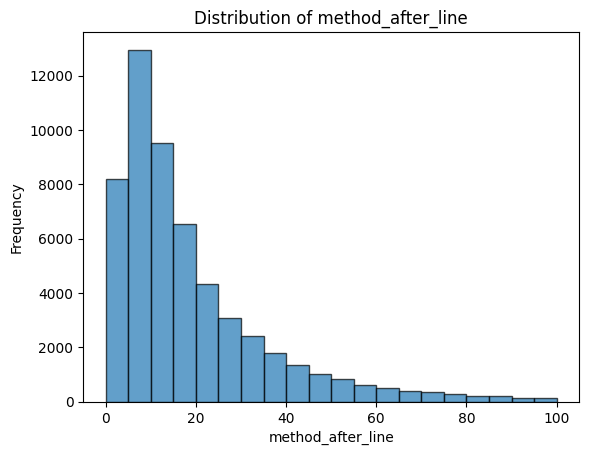

method_after_line >= 100: 0.019764823617713284
count    55958.000000
mean        21.282926
std         33.388128
min          1.000000
25%          7.000000
50%         13.000000
75%         25.000000
max       3336.000000
Name: method_after_line, dtype: float64
----------------------------------------------------------------------------------------------------
added_line
saved @ data/plots/added_line_distribution.png


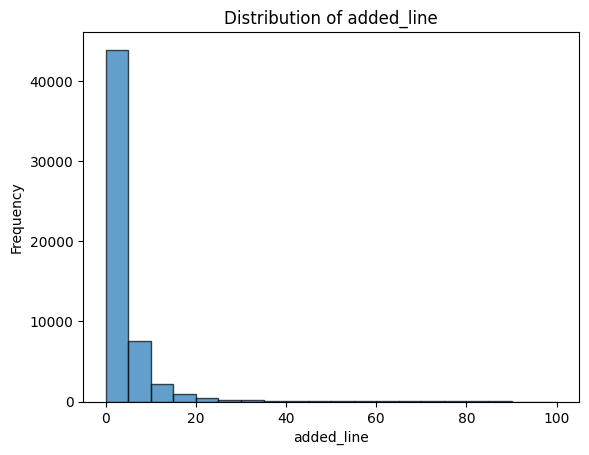

added_line >= 100: 0.0008041745594910469
count    55958.000000
mean         3.822563
std         12.759300
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       2336.000000
Name: added_line, dtype: float64
----------------------------------------------------------------------------------------------------
removed_line
saved @ data/plots/removed_line_distribution.png


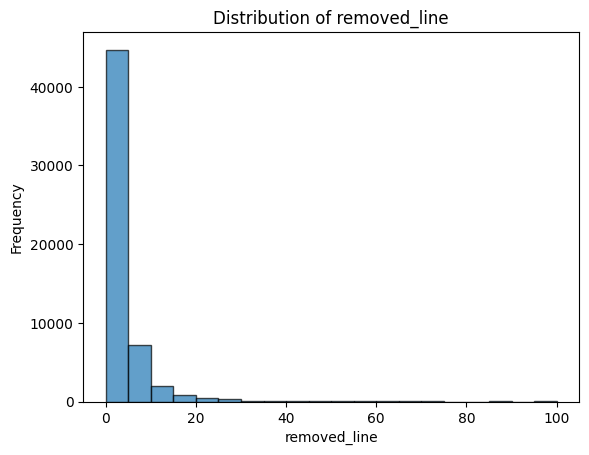

removed_line >= 100: 0.0007684334679581114
count    55958.000000
mean         3.528235
std          8.031717
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        646.000000
Name: removed_line, dtype: float64
----------------------------------------------------------------------------------------------------
changed_line
saved @ data/plots/changed_line_distribution.png


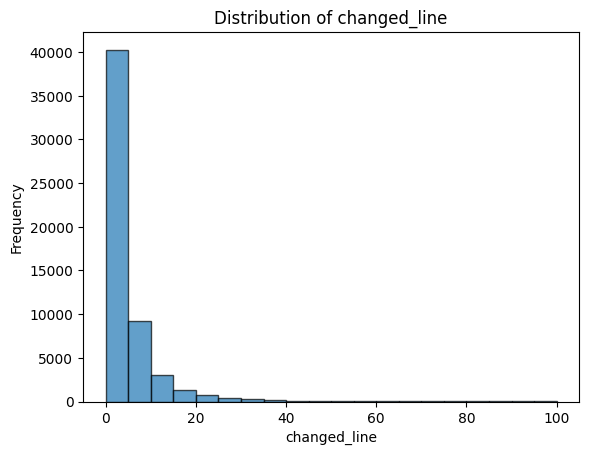

changed_line >= 100: 0.0013760320240180136
count    55958.000000
mean         4.839147
std         13.920042
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       2336.000000
Name: changed_line, dtype: float64
----------------------------------------------------------------------------------------------------


In [5]:
method_columns = [
    'method_before_token',
    'method_after_token',

    'added_token',
    'removed_token',

    'changed_token',

    'method_before_line',
    'method_after_line',

    'added_line',
    'removed_line',

    'changed_line',
]

max_line = 100
max_token = 1024

for column in method_columns:
    print(column)
    if (column.endswith('line')):
        plot_column_by_bins(data_df, column, col_max = max_line, bins = 20)
        print(f'{column} >= {max_line}: {len(data_df[data_df[column] > max_line]) / len(data_df)}')
    else:
        plot_column_by_bins(data_df, column, col_max = max_token, bins = 20)
        print(f'{column} >= {max_token}: {len(data_df[data_df[column] > max_token]) / len(data_df)}')
    print(data_df[column].describe())
    print('-' * 100)

### create dataset cutoff

In [13]:
max_token = 256

cutoff_by_tokens_df = data_df[
    # (data_df['method_before_token'] <= max_token)
    (data_df['method_after_token'] <= max_token)
]

In [14]:
print(f'percent of the new dataset: {len(cutoff_by_tokens_df) / len(data_df)}')

percent of the new dataset: 0.716644626326888


In [ ]:
cutoff_by_tokens_df_dropped = cutoff_by_tokens_df.drop(columns = method_columns, inplace = False, errors = 'raise')
cutoff_by_tokens_df_dropped.reset_index(drop = True, inplace = True)
cutoff_by_tokens_df_dropped.loc[:, 'id'] = cutoff_by_tokens_df_dropped.index

In [ ]:
cutoff_by_tokens_df_dropped

In [ ]:
cutoff_by_tokens_df_dropped.to_parquet(f'{data_prefix}/migration_others_dataset_cutoff_{max_token}.parquet', engine = 'pyarrow')